# MNIST digits classification: 4 solutions

**Source (all credits to):** *Coursera: Intro to Deep Learning Course* and *Easy TensorFlow*

<img src="../resources/mnist_sample.png" style="width:30%">

Solutions:

1. Logistic Regression.
2. Multilayer Perceptron (MLP) with 2 Hidden Layers.
3. Convolutional Neural Network (CNN).
4. Recurrent Neural Network (RNN).

# 1. Import Libraries

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf # pip install tensorflow 1.2.1
import keras
import keras.backend as K

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

print("We're using TensorFlow", tf.__version__)
print("We're using Keras", keras.__version__)

# use TensorFlow v.1
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()

We're using TensorFlow 2.4.1
We're using Keras 2.4.3


# 2. Prepare Data

## 2.1. Preprocessing Data

In [3]:
def preprocessing_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

## 2.2. Load Data

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessing_dataset()

print('Shapes')
print('---')
print('X_train =', X_train.shape)
print('y_train =', y_train.shape)
print('X_test =', X_test.shape)
print('y_test =', y_test.shape)
print()
print('Shapes for linear model')
print('---')

X_train_flat = X_train.reshape((X_train.shape[0], -1))
print('Flat X_train =', X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print('Flat X_val =', X_val_flat.shape)
print()
print('Shapes for cross-entropy')
print('---')

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print('One-hot-encoded y_train =', y_train_oh.shape)
print('One-hot-encoded y_val =', y_val_oh.shape)

X_test_flat = X_test.reshape((X_test.shape[0], -1))
y_test_oh = keras.utils.to_categorical(y_test, 10)

Shapes
---
X_train = (50000, 28, 28)
y_train = (50000,)
X_test = (10000, 28, 28)
y_test = (10000,)

Shapes for linear model
---
Flat X_train = (50000, 784)
Flat X_val = (10000, 784)

Shapes for cross-entropy
---
One-hot-encoded y_train = (50000, 10)
One-hot-encoded y_val = (10000, 10)


## 2.3. Look at Data

Example of a manuscript digit


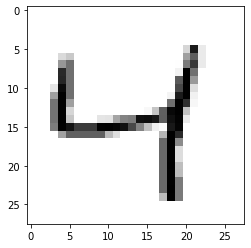

Sample patch of the manuscript digit


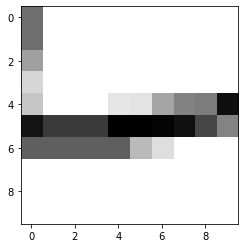

In [5]:
print('Example of a manuscript digit')

plt.imshow(X_train[2], cmap="Greys")
plt.show()

print('Sample patch of the manuscript digit')

plt.imshow(X_train[2, 10:20, 5:15], cmap="Greys")
plt.show()

# 3. Solution 1 - Linear Model (Logistic Regression)

<img src="../resources/linear_classifier.png" style="width:80%">

In [ ]:
# data dimensions
input_size = len(X_train_flat[1])
n_classes = len(y_train_oh[1])

# clear context
K.clear_session()

# hyper-parameters
EPOCHS = 10
BATCH_SIZE = 100
DISPLAY_FREQ = 100      # frequency of displaying the training results
LEARNING_RATE = 0.001

# model input data
x = tf.placeholder(tf.float32, shape=[None, input_size], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')
 
# model parameters: W (weights) and b (bias)
W = weight_variable(shape=[input_size, n_classes])
b = bias_variable(shape=[n_classes])

# calculate logits (forward output)
#output_logits = tf.matmul(x, W) + b
output_logits = x @ W + b

######## prepare model ########

# loss function = softmax with cross-entropy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')

# optimizer = Adam
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, name='Adam-op').minimize(loss)

# model prediction
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')

# model accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# model predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')
 
# initialize tf variables
init = tf.global_variables_initializer()
 
######## train model ########

# create a tf session
sess = tf.InteractiveSession()

# initialize session variables
sess.run(init)

num_tr_iter = int(len(y_train) / BATCH_SIZE) # ~500 iterations

for epoch in range(EPOCHS):
    print('Training epoch: {}'.format(epoch + 1))
    
    # randomly shuffle the training data at the beginning of each epoch 
    x_train, y_train = randomize(X_train_flat, y_train_oh)
    
    for iteration in range(num_tr_iter):
        start = iteration * BATCH_SIZE
        end = (iteration + 1) * BATCH_SIZE
        
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # run optimization (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % DISPLAY_FREQ == 0:
            
            # calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy], feed_dict=feed_dict_batch)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # run validation after every epoch
    feed_dict_valid = {x: X_val_flat[:1000], y: y_val_oh[:1000]}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')
    
######## test model ########

feed_dict_test = {x: X_test_flat, y: y_test_oh}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)

print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

######## plot results ########

# plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test_oh, axis=1)

plot_images(X_test_flat, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(X_test_flat, cls_true, cls_pred, title='Misclassified Examples')
plt.show()

sess.close()

# 4. Solution 2 - MLP

<img src="../resources/nn.png" style="width:100%">

In [ ]:
# data dimensions
input_size = len(X_train_flat[1])
n_classes = len(y_train_oh[1])

# clear context
K.clear_session()

# model input data
x = tf.placeholder(tf.float32, shape=[None, input_size], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')
 
# model parameters: W (weights) and b (bias)
W = weight_variable(shape=[input_size, n_classes])
b = bias_variable(shape=[n_classes])

# hyper-parameters
EPOCHS = 13
BATCH_SIZE = 100
DISPLAY_FREQ = 100      # frequency of displaying the training results
LEARNING_RATE = 0.001
h1 = 200                # number of neurons in the 1st hidden layey

######## prepare model ########

# create a fully-connected layer with h1 nodes as hidden layer
fc1 = fc_layer(x, h1, 'FC1', use_relu=True)

# create a fully-connected layer with n_classes nodes as output layer
output_logits = fc_layer(fc1, n_classes, 'OUT', use_relu=False)

# loss function = softmax with cross-entropy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')

# optimizer = Adam
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, name='Adam-op').minimize(loss)

# model prediction
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')

# model accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# model predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')
 
# initialize tf variables
init = tf.global_variables_initializer()

# model predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')
 
# initialize tf variables
init = tf.global_variables_initializer()
 
######## train model ########

# create a tf session
sess = tf.InteractiveSession()

# initialize session variables
sess.run(init)

num_tr_iter = int(len(y_train) / BATCH_SIZE) # ~500 iterations

for epoch in range(EPOCHS):
    print('Training epoch: {}'.format(epoch + 1))
    
    # randomly shuffle the training data at the beginning of each epoch 
    x_train, y_train = randomize(X_train_flat, y_train_oh)
    
    for iteration in range(num_tr_iter):
        start = iteration * BATCH_SIZE
        end = (iteration + 1) * BATCH_SIZE
        
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # run optimization (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % DISPLAY_FREQ == 0:
            
            # calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy], feed_dict=feed_dict_batch)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # run validation after every epoch
    feed_dict_valid = {x: X_val_flat[:1000], y: y_val_oh[:1000]}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')
    
######## test model ########
feed_dict_test = {x: X_test_flat, y: y_test_oh}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)

print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

######## plot results ########

# plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test_oh, axis=1)

plot_images(X_test_flat, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(X_test_flat, cls_true, cls_pred, title='Misclassified Examples')
plt.show()

sess.close()

# 5. Solution 3 - CNN

<img src="../resources/cnn.png" style="width:100%">

In [ ]:
# data dimensions
input_size = len(X_train_flat[1])
n_classes = len(y_train_oh[1])
img_h = len(X_train[1])         # MNIST images are 28x28
img_w = len(X_train[0])
img_size_flat = img_h * img_w   # 28x28=784, the total number of pixels
n_channels = 1

# clear context
K.clear_session()

# model input data

# reformats the data to the format acceptable for convolutional layers
x_train, _ = reformat(X_train_flat, y_train_oh)
x_valid, _ = reformat(X_val_flat, y_val_oh)
x_test, _ = reformat(X_test_flat, y_test_oh)

with tf.name_scope('Input'):
    x = tf.placeholder(tf.float32, shape=[None, img_h, img_w, n_channels], name='X')
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')
    
# hyper-parameters
EPOCHS = 10
BATCH_SIZE = 100
DISPLAY_FREQ = 100      # frequency of displaying the training results
LEARNING_RATE = 0.001
LOGS_PATH = "./logs"    # path to the folder that we want to save the logs for Tensorboard

######## prepare model ########

# network configuration

# 1st Convolutional Layer
filter_size1 = 5   # Convolution filters are 5 x 5 pixels.
num_filters1 = 16  # There are 16 of these filters.
stride1 = 1        # The stride of the sliding window

# 2nd Convolutional Layer
filter_size2 = 5   # Convolution filters are 5 x 5 pixels.
num_filters2 = 32  # There are 32 of these filters.
stride2 = 1        # The stride of the sliding window

# Fully-connected layer.
h1 = 128           # Number of neurons in fully-connected layer.

# create the network layers
conv1 = conv_layer(x, filter_size1, num_filters1, stride1, name='conv1')
pool1 = max_pool(conv1, ksize=2, stride=2, name='pool1')
conv2 = conv_layer(pool1, filter_size2, num_filters2, stride2, name='conv2')
pool2 = max_pool(conv2, ksize=2, stride=2, name='pool2')
layer_flat = flatten_layer(pool2)
fc1 = fc_layer(layer_flat, h1, 'FC1', use_relu=True)
output_logits = fc_layer(fc1, n_classes, 'OUT', use_relu=False)

# loss function = softmax with cross-entropy
with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
    tf.summary.scalar('loss', loss)

    # optimizer = Adam
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, name='Adam-op').minimize(loss)
        
    # model prediction
    with tf.variable_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')

    # model accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    tf.summary.scalar('accuracy', accuracy)
    
    # model predictions
    with tf.variable_scope('Prediction'):
        cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')
        
# initialize tf variables
init = tf.global_variables_initializer()

# Merge all summaries
merged = tf.summary.merge_all()
 
######## train model ########

# create a tf session
sess = tf.InteractiveSession()

# initialize session variables
sess.run(init)

num_tr_iter = int(len(y_train) / BATCH_SIZE) # ~500 iterations

# log training proccess
global_step = 0
summary_writer = tf.summary.FileWriter(LOGS_PATH, sess.graph)

# shuffle the before training
x_train, y_train = randomize(x_train, y_train_oh)

for epoch in range(EPOCHS):
    print('Training epoch: {}'.format(epoch + 1))
    
    # randomly shuffle the training data at the beginning of each epoch 
    x_train, y_train = randomize(x_train, y_train)
    
    for iteration in range(num_tr_iter):
        global_step += 1
        start = iteration * BATCH_SIZE
        end = (iteration + 1) * BATCH_SIZE
        x_batch, y_batch = get_next_batch(x_train, y_train, start, end)

        # run optimization (backprop)
        feed_dict_batch = {x: x_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)

        if iteration % DISPLAY_FREQ == 0:
            # calculate and display the batch loss and accuracy
            loss_batch, acc_batch, summary_tr = sess.run([loss, accuracy, merged],
                                                         feed_dict=feed_dict_batch)
            summary_writer.add_summary(summary_tr, global_step)

            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # run validation after every epoch
    feed_dict_valid = {x: x_valid, y: y_val_oh}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')
    
######## test model ########
feed_dict_test = {x: x_test, y: y_test_oh}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)

print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

######## plot results ########

# plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(y_test_oh, axis=1)

plot_images(X_test_flat, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test, cls_true, cls_pred, title='Misclassified Examples')
plt.show()

sess.close()

# 6. Solution 4 - RNN

<img src="../resources/rnn.png" style="width:80%">

In [7]:
print('Doing...')

Doing...


# 99. Functions Used

In [ ]:
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W',
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b',
                           dtype=tf.float32,
                           initializer=initial)

def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(28, 28), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)

def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)
    
# weight wrapper for Neural Network (NN)
def weight_variable_NN(name, shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

# bias wrapper for Neural Network (NN)
def bias_variable_NN(name, shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)

def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    in_dim = x.get_shape()[1]
    W = weight_variable_NN(name, shape=[in_dim, num_units])
    b = bias_variable_NN(name, [num_units])
    layer = tf.matmul(x, W)
    layer += b
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

def reformat(x, y):
    """
    Reformats the data to the format acceptable for convolutional layers
    :param x: input array
    :param y: corresponding labels
    :return: reshaped input and labels
    """
    img_size, num_ch, num_class = int(np.sqrt(x.shape[-1])), 1, len(np.unique(np.argmax(y, 1)))
    dataset = x.reshape((-1, img_size, img_size, num_ch)).astype(np.float32)
    labels = (np.arange(num_class) == y[:, None]).astype(np.float32)
    return dataset, labels

def conv_layer(x, filter_size, num_filters, stride, name):
    """
    Create a 2D convolution layer
    :param x: input from previous layer
    :param filter_size: size of each filter
    :param num_filters: number of filters (or output feature maps)
    :param stride: filter stride
    :param name: layer name
    :return: The output array
    """
    with tf.variable_scope(name):
        num_in_channel = x.get_shape().as_list()[-1]
        shape = [filter_size, filter_size, num_in_channel, num_filters]
        W = weight_variable(shape=shape)
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_filters])
        tf.summary.histogram('bias', b)
        layer = tf.nn.conv2d(x, W,
                             strides=[1, stride, stride, 1],
                             padding="SAME")
        layer += b
        return tf.nn.relu(layer)


def max_pool(x, ksize, stride, name):
    """
    Create a max pooling layer
    :param x: input to max-pooling layer
    :param ksize: size of the max-pooling filter
    :param stride: stride of the max-pooling filter
    :param name: layer name
    :return: The output array
    """
    return tf.nn.max_pool(x,
                          ksize=[1, ksize, ksize, 1],
                          strides=[1, stride, stride, 1],
                          padding="SAME",
                          name=name)

def flatten_layer(layer):
    """
    Flattens the output of the convolutional layer to be fed into fully-connected layer
    :param layer: input array
    :return: flattened array
    """
    with tf.variable_scope('Flatten_layer'):
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    with tf.variable_scope(name):
        in_dim = x.get_shape()[1]
        W = weight_variable(shape=[in_dim, num_units])
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_units])
        tf.summary.histogram('bias', b)
        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer